# Desafío final integrador - Equipo 10
## Clasificador de géneros musicales
### Dada la letra de una canción, el algoritmo la clasifica dentro de un conjunto de géneros estándar.
### Realizado a partir de un dataset de 362.237 filas con letras predominantemente en idioma inglés, seguimos el siguiente plan de trabajo:

HIPÓTESIS: 
Clasificar género a partir de las letras

PASO A PASO:

PREPROCESAMIENTO:
Limpieza del data set:
sacamos NaNs
sacamos años outliers
sacamos los que no tenían género etiquetado
sacamos canciones con poca cantidad de palabras (menos de 50, más de 1000)
Traducción de letras a inglés (con herramientas gratuitas no funcionó)
sacamos canciones en idiomas distintos a inglés 

Data set desbalanceado: 
años 
género: lo vamos a balancear (oversampling, SMOTE)

EDA

Stop Words
Pasamos CV y TF
Topic Modelling: elegimos 40 tópicos
LDA: procesaba mejor las stop words
Tópicos que tienen sentido + Wordcloud para cada topico + PyLDAvis
Sentiment Analysis: 
Análisis de sentimiento de cada género y determinados artistas

Clasificacion
Eleccion de features: Topicos, array de tpopicos, array de sentimientos, año


### Intentamos traducir las letras distintas de inglés, pero las dos API gratuitas que encontramos no permiten hacer procesamiento masivo.
Se intentó con googletrans, y con translate.
Translate permite traducir hasta 500 caracteres por llamado.
En cambio utilizamos googletrans, pero la API gratuita no asegura un funcionamiento estable. 
#### El código de la celda siguiente funciona, pero la API googletrans comienza a dar error aleatoriamente luego de varios cientos o miles de filas. 
Con la versión comercial, esta rutina debería traducir el dataset completo.

In [ ]:
from googletrans import Translator
from langdetect import detect 
import datetime
import pandas as pd

try: 
    cantidad = 40
    hora = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('Empiezo...' + hora)
    df = pd.read_csv("lyrics.csv").dropna()
    #Dropeamos años outliers
    df.drop([315540,147914,335205,238541,69708,27657],inplace = True)
    # dropeo casos particulares
    #df = df[df.artist!='dicaiaaoi-aeaenaiad']
    
    df.reset_index(inplace=True)
    df = df.drop(['level_0'], axis=1)
    df['index']=  df.index
 
    dftrans = df.copy(deep=True)
    dftrans.drop(dftrans.index, inplace=True) # creo el nuevo df de lyrics vacio
    
    i = 0
    j = 0
    translator = Translator()
    for letra in df.lyrics:
        #letra = letra.replace("\n", ".")
        try:   # esto es para saltear problemas en la detección de idioma
            idioma = detect(letra)
        except:
            #print('Registro ', i, ' con problemas. Letra:', df.lyrics[i])
            #print('Error! Code: {c}, Message, {m}'.format(c=type(e).__name__, m=str(e)))
            i += 1
            continue # lo salteo y voy al siguiente registro
        if idioma == 'en':  
            dftrans.loc[j] = [j, df.song[i], df.year[i], df.artist[i], df.genre[i], letra]
            j += 1
        else:   # para traducir uso googletrans
            try:   # esto es para saltear problemas en la traducción          
                translation = translator.translate(letra, src=idioma, dest='en')
                letra = translation.text
                dftrans.loc[j] = [j, df.song[i], df.year[i], df.artist[i], df.genre[i], letra]
                print('registro traducido a inglés...' ,dftrans.song[j])
                j += 1
            except Exception as e:
                print('Registro ', i, ' con problemas de traducción')
                print('Error! Code: {c}, Message, {m}'.format(c=type(e).__name__, m=str(e)))
                i += 1
                continue # lo salteo y voy al siguiente registro
                 
        if i > cantidad:
            break
        i+=1
        
    dftrans.to_csv('lyrics_trans.csv')
    hora = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('Terminé...' + hora)

except Exception as e:
    dftrans.to_csv('lyrics_trans.csv')
    print('Registro ', i, ' cancelado!')
    print('Error! Code: {c}, Message, {m}'.format(c=type(e).__name__, m=str(e)))

## La celda a continuación, selecciona las letras en inglés y deshecha las demás. Genera un nuevo dataset limpio para continuar con el pipeline.
El proceso de selección elimina automáticamente también las filas cuyo campo LYRICS contenga basura, ya que la función no puede determinar que sean idioma inglés.

In [ ]:
from langdetect import detect 
import datetime
import pandas as pd

try: 
    cantidad = 400000
    hora = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('Empiezo...' + hora)
    df = pd.read_csv("lyrics.csv").dropna()
    #Dropeamos años outliers
    df.drop([315540,147914,335205,238541,69708,27657],inplace = True)
    # dropeo casos particulares
    #df = df[df.artist!='dicaiaaoi-aeaenaiad']
    
    #
    df.reset_index(inplace=True)
    df = df.drop(['level_0'], axis=1)
    df['index']=  df.index
 
    dftrans = df.copy(deep=True)
    dftrans.drop(dftrans.index, inplace=True) # creo el nuevo df de lyrics vacio
    
    i = 0
    j = 0
    for letra in df.lyrics:
        #letra = letra.replace("\n", ".")
        try:   # esto es para saltear problemas multiples con el contenido de las letras
            idioma = detect(letra)
        except Exception as e:
            print('Registro ', i, ' con problemas. Letra:', df.lyrics[i])
            print('Error! Code: {c}, Message, {m}'.format(c=type(e).__name__, m=str(e)))
            i+=1
            continue # lo salteo y voy al siguiente registro
        if idioma == 'en':  
            dftrans.loc[j] = [j, df.song[i], df.year[i], df.artist[i], df.genre[i], letra]
            # por ahora solo paso las canciones en inglés
            #translation = translator.translate(letra, src=translation.lang, dest='en')
            #letra = translation.text
            #print('registro inglés...' ,dftrans.song[j])
            j += 1
        #else:
            #print('registro NO-inglés ',i,'...' ,df.song[i])
            
        if i > cantidad:
            break
        i+=1
        
    dftrans.to_csv('lyrics_solo_ingles.csv')
    hora = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('Terminé...' + hora)

except Exception as e:
    dftrans.to_csv('lyrics_solo_ingles.csv')
    print('Registro ', i, ' cancelado!')
    print('Error! Code: {c}, Message, {m}'.format(c=type(e).__name__, m=str(e)))

### Tomamos el resultado del proceso anterior y continuamos con la limpieza

In [1]:
import pandas as pd

In [2]:
# Tomamos el nuevo dataset generado por el traductor
df = pd.read_csv("lyrics_solo_ingles.csv").dropna()
# cambiamos caracteres especiales por "." 
df = df.replace({'\n': ' ',"\r":"."}, regex=True)

In [3]:
# Contamos la cantidad de caracteres de las canciones
df['word_count'] = df['lyrics'].str.split().str.len()
df["word_count"].groupby(df["genre"]).describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Country,14253.0,187.038097,82.157019,3.0,129.0,171.0,231.0,1366.0
Electronic,7003.0,207.034271,135.379783,2.0,114.0,182.0,267.0,1920.0
Folk,1787.0,202.385003,118.163203,4.0,130.0,182.0,254.0,2393.0
Hip-Hop,23039.0,496.701333,239.747452,2.0,344.0,493.0,637.0,8196.0
Indie,2974.0,198.907868,100.002221,11.0,129.0,185.0,250.0,1262.0
Jazz,7351.0,174.607672,95.404001,2.0,110.0,153.0,215.0,1040.0
Metal,21523.0,177.528737,110.729725,1.0,108.0,158.0,222.5,2423.0
Not Available,17583.0,232.447023,133.837566,1.0,144.0,207.0,291.0,2269.0
Other,3992.0,225.924850,141.890102,3.0,126.0,193.0,290.0,1569.0


In [4]:
# Desechamos las canciones con menos de 50 caracteres y más de 1000
df_clean = df.loc[df["word_count"] > 50]
df_clean = df_clean.loc[df["word_count"]<1000]
df_clean["word_count"].groupby(df_clean["genre"]).describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Country,14147.0,188.135859,80.691829,51.0,130.0,172.0,231.0,895.0
Electronic,6535.0,218.899005,128.005877,51.0,128.0,192.0,274.0,990.0
Folk,1739.0,205.085681,100.601054,51.0,134.5,185.0,256.0,998.0
Hip-Hop,22085.0,493.542767,199.618838,51.0,352.0,493.0,631.0,999.0
Indie,2908.0,202.244498,95.975984,52.0,133.0,187.0,252.0,934.0
Jazz,7215.0,177.151074,93.705478,51.0,112.0,154.0,216.5,935.0
Metal,20377.0,185.139765,102.898585,51.0,115.0,163.0,227.0,999.0
Not Available,17034.0,237.574968,126.289407,51.0,149.0,210.0,294.0,994.0
Other,3895.0,229.725546,136.335595,51.0,130.0,196.0,292.0,932.0


In [5]:
# Agrupamos las canciones por género
genre = df_clean.groupby(['genre'],as_index=False).count()
genre2 = genre[['genre','song']]
genre2

,genre,song
0,Country,14147
1,Electronic,6535
2,Folk,1739
3,Hip-Hop,22085
4,Indie,2908
5,Jazz,7215
6,Metal,20377
7,Not Available,17034
8,Other,3895
9,Pop,34295


In [6]:
# Limpiamos las canciones con géneros no etiquetados

df_clean.loc[df["genre"] == "Not Available"].groupby("artist").count()

,Unnamed: 0,index,song,year,genre,lyrics,word_count
artist,,,,,,,
0510,1,1,1,1,1,1,1
0510-ent,1,1,1,1,1,1,1
1-girl-nation,10,10,10,10,10,10,10
1-hundredd,1,1,1,1,1,1,1
100-percent,1,1,1,1,1,1,1
10ille,3,3,3,3,3,3,3
1140-mississippi,9,9,9,9,9,9,9
15-minutes-of-fame,2,2,2,2,2,2,2
1985-chicago-bears,1,1,1,1,1,1,1


In [7]:
df_clean.describe()

,Unnamed: 0,index,year,word_count
count,231714.000000,231714.000000,231714.000000,231714.000000
mean,119107.836354,119107.836354,2007.620045,237.281286
std,68752.463989,68752.463989,5.322654,145.700698
min,0.000000,0.000000,1968.000000,51.000000
25%,59485.250000,59485.250000,2006.000000,140.000000
50%,119179.500000,119179.500000,2007.000000,200.000000
75%,178596.750000,178596.750000,2010.000000,287.000000
max,238232.000000,238232.000000,2016.000000,999.000000


In [8]:
df_clean2 = df_clean.loc[df_clean["genre"] != "Other"]

In [9]:

df_clean2 = df_clean2.loc[df_clean["genre"] != "Not Available"]
df_clean2.describe()

,Unnamed: 0,index,year,word_count
count,210785.000000,210785.000000,210785.000000,210785.000000
mean,119423.507375,119423.507375,2007.430334,237.397172
std,68819.917068,68819.917068,5.280992,147.320243
min,0.000000,0.000000,1968.000000,51.000000
25%,59613.000000,59613.000000,2006.000000,139.000000
50%,119300.000000,119300.000000,2007.000000,199.000000
75%,179040.000000,179040.000000,2010.000000,286.000000
max,238232.000000,238232.000000,2016.000000,999.000000


In [10]:
df_clean2["genre"].value_counts()

Rock          98176
Pop           34295
Hip-Hop       22085
Metal         20377
Country       14147
Jazz           7215
Electronic     6535
R&B            3308
Indie          2908
Folk           1739
Name: genre, dtype: int64

In [11]:
df_clean.loc[df_clean["genre"] == "Not Available"].groupby("artist").count()

,Unnamed: 0,index,song,year,genre,lyrics,word_count
artist,,,,,,,
0510,1,1,1,1,1,1,1
0510-ent,1,1,1,1,1,1,1
1-girl-nation,10,10,10,10,10,10,10
1-hundredd,1,1,1,1,1,1,1
100-percent,1,1,1,1,1,1,1
10ille,3,3,3,3,3,3,3
1140-mississippi,9,9,9,9,9,9,9
15-minutes-of-fame,2,2,2,2,2,2,2
1985-chicago-bears,1,1,1,1,1,1,1


In [12]:
genre_clean = df_clean2.groupby("genre",as_index = False).count()
genre_clean[["genre","song"]]

,genre,song
0,Country,14147
1,Electronic,6535
2,Folk,1739
3,Hip-Hop,22085
4,Indie,2908
5,Jazz,7215
6,Metal,20377
7,Pop,34295
8,R&B,3308
9,Rock,98176


In [13]:
df_clean2["genre"].value_counts(True)

Rock          0.465764
Pop           0.162701
Hip-Hop       0.104775
Metal         0.096672
Country       0.067116
Jazz          0.034229
Electronic    0.031003
R&B           0.015694
Indie         0.013796
Folk          0.008250
Name: genre, dtype: float64

In [14]:
# guardamos el dataset limpio por si hace falta
df_clean2.to_csv("df_limpio.csv")

### Preprocesamiento del dataset
- Incorporamos stopwords
- Vectorizamos
- Separamos por tópicos, LDA y NMF


In [2]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text 

In [16]:
lyrics = df_clean2["lyrics"].tolist()

# Stop words propias, tomadas del proceso de exploración
stop_words_extra = ({"baby","instrumental", "music", "lyrics", "song", "track", "guitar", "written"," band"," road", "black", "piece", "break", "verse", "solo", "singing", "lead", "single",
"oh oh", "oh oh oh", "whoa", "ooh", "ah", "uh", "oh yeah", "oh baby",
"yeah", "yeah yeah", "yeah yeah yeah", "oh yeah", "ooh", "uh", "ah", "whoa",
"chorus", "verse", "repeat", "x2", "bridge", "2x", "solo", "music", "gotta", "stop",
"oh oh", "oh oh oh", "yeah", "oh yeah", "uh",
"hey", "hey hey", "ve", "ll", "im"})

In [17]:
# Agregamos stopwords genéricas
stop_words = text.ENGLISH_STOP_WORDS.union(stop_words_extra)
stop_words

frozenset({' band',
           ' road',
           '2x',
           'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'ah',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'baby',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
         

### Pasamos CV y TF

In [18]:
count_vect = CountVectorizer(ngram_range= (1,3), max_df = 0.20, min_df = 0.01,stop_words=stop_words, lowercase=True)
x_counts = count_vect.fit_transform(lyrics)

In [19]:
tfidf_transformer = TfidfTransformer(norm = 'l2')
x_tfidf = tfidf_transformer.fit_transform(x_counts)

### Realizamos NMF pero resultó mejor el procesamiento con LDA, como se puede ver más abajo

In [ ]:
dim = 40
#Realizo NMF
nmf = NMF(n_components = dim)
nmf_array = nmf.fit_transform(x_tfidf)

In [ ]:
labels = [np.argmax(x) for x in nmf_array]
nmf

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=40, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

### Corremos LDA

In [ ]:
lda = LDA(n_components = 40)
lda_array = lda.fit_transform(x_tfidf)

Creamos los Df para ver las palabras principales

In [ ]:
lista_prueba = []
dicc_topicos = {}

components = [lda.components_[i] for i in range(len(lda.components_))]
features = count_vect.get_feature_names()
for j in range(len(components)):

    comp = components[j]
    print (j)
    prior_features = sorted(features, key = lambda x: comp[features.index(x)], reverse = True)
    print(prior_features)
    dicc_topicos.update({j:prior_features})

df_pruebation = pd.DataFrame(dicc_topicos)


In [ ]:
np.sort(lda.components_[2])[-20:]

In [ ]:
for x in lda.components_[0]:
    print(x/np.linalg.norm(lda.components_[0]))

In [ ]:
df_pruebation = df_pruebation[:20]
df_pruebation.iloc[:,:20]

In [ ]:
df_pruebation.rename(columns = {0:"love_and_party",1:"hood_rap",2:"dance",3:"soul_searching",
                                6:"romantic_love",7:"religious",8:"live_life"},inplace = True)

In [ ]:
df_clean2.reset_index(inplace = True)

In [ ]:
df_topico = df_array.idxmax(axis=1)
df_array.rename(columns = {0:"cero"},inplace = True)

In [ ]:
# Exportamos el resultado a un CSV para utilizarlo más adelante
df_export = pd.concat((df_clean2,df_array),axis=1)
df_export.to_csv("clasificar.csv")

In [ ]:
df_analisis = pd.concat((df_clean2,df_topico,df_array),axis = 1)

In [ ]:
df_analisis.rename(columns = {0:"topico"},inplace = True)

## Sentiment Analysis
Realizamos un Sentiment Analysis sobre las letras de las canciones, para agregar una nueva feature al dataset, de acuerdo al resultado del análisis. Esta feature, esperamos que colabore en la clasificación.

In [ ]:
#!pip install py_lex

In [4]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dronc\AppData\Roaming\nltk_data...


True

In [11]:
#from py_lex import EmoLex
#lexicon = EmoLex('Emotion-Lexicon.txt')
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
lyrics = pd.read_csv("lyrics_solo_ingles.csv")

In [7]:
#Hacemos inicializacion de las columnas
lyrics["tokens"] = pd.Series(dtype=object)
lyrics['anger'] = 0.0
lyrics['anticipation'] = 0.0
lyrics['disgust'] = 0.0
lyrics['fear'] = 0.0
lyrics['joy'] = 0.0
lyrics['negative'] = 0.0
lyrics['positive'] = 0.0
lyrics['sadness'] = 0.0
lyrics['surprise'] = 0.0
lyrics['trust'] = 0.0

In [12]:
#Hacemos una lista con las palabras de las canciones
stopset = set(stopwords.words())
for index, row in lyrics.iterrows():
        tokens = word_tokenize(row['lyrics'].replace("\n"," ").replace("\r","").replace(",","").replace(".","").lower())
        tokens_wo_stopwords = [word for word in tokens if not word in stopset]
        lyrics.at[index, 'tokens'] = tokens_wo_stopwords

In [ ]:
#Hacemos las pruebas sobre las canciones y las llevamos al dataset
for index, _ in lyrics.iterrows():
    summary = lexicon.summarize_doc(lyrics.loc[index].tokens)
    for key in summary.keys():
        lyrics.at[index, key] = summary[key]

In [ ]:
#funcion para mostrar los resultados
def Muestra(df):
    total_sentiments = pd.DataFrame(df.sum()[['fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust']].sort_values(ascending=False))
    colors = ['pink', 'midnightblue', 'orange', 'yellow', 'grey', 'lightskyblue', 'orangered',  'olive']
    total_sentiments.columns = ['value']

    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.barplot(x=total_sentiments.index, y='value', data=total_sentiments, palette=sns.color_palette(colors))
    plt.ylabel("")
    plt.xlabel('Emotion', fontsize=20)
    plt.title('Distribution of values from NRC emotions', fontsize=25)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    sns.despine()
    plt.plot();

In [ ]:
#Llevamos nuestros valores a disco
lyrics.to_csv("All_sentimens.csv")
lyrics.drop(["Unnamed: 0","genre","artist","year","song","lyrics","tokens"],axis=1).to_csv("Only_English_Sentiments_All.csv")

In [ ]:
### Exploramos los sentimientos por géneros (de algunos géneros)

In [ ]:
#Hacemos una muestra por generos
Sentimientos_musicales = lyrics.drop(["tokens","Unnamed: 0"],axis=1)

In [ ]:
Muestra(Sentimientos_musicales[Sentimientos_musicales["genre"] == "Metal"].drop(columns=["lyrics","index","song","year","artist","genre"]))

In [ ]:
Muestra(Sentimientos_musicales[Sentimientos_musicales["genre"] == "Jazz"].drop(columns=["artist","index","song","year","artist","genre"]))

In [ ]:
Muestra(Sentimientos_musicales[Sentimientos_musicales["genre"] == "Country"].drop(columns=["artist","index","song","year","artist","genre"]))

In [ ]:
total_sentiments = pd.DataFrame(gorillaz.sum()[['fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust']].sort_values(ascending=False))
colors = ['pink', 'midnightblue', 'orange', 'yellow', 'grey', 'lightskyblue', 'orangered',  'olive']
total_sentiments.columns = ['value']

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x=total_sentiments.index, y='value', data=total_sentiments, palette=sns.color_palette(colors))
plt.ylabel("")
plt.xlabel('Emotion', fontsize=20)
plt.title('Distribution of values from NRC emotions', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
sns.despine()
plt.plot();

## Análisis exploratorio del contenido de los tópicos utilizando Word Clouds
### Tomamos el resultado del análisis LDA, los tópicos, las palabras, y sus pesos

In [1]:
# Hago un LDA de Gensim para graficarlo con word clouds

import sys
import datetime
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore")
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
   
df = pd.read_csv("lyrics_solo_ingles.csv", encoding='utf-8').dropna()
data_words = df.lyrics.values.tolist()

warnings.filterwarnings("ignore")

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """saco Stopwords, de  Bigrams, Trigrams y Lemmatizacion"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # saco stopwords otra vez despues de la lemmatizacion
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # Texto preprocesado

warnings.filterwarnings("ignore")
# Creo el Dictionario
id2word = corpora.Dictionary(data_ready)

# Creando el Corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

#  LDA 
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=5,
                                           per_word_topics=True)

In [2]:
pprint(lda_model.print_topics(num_words =40))

[(0,
  '0.035*"man" + 0.021*"lord" + 0.020*"god" + 0.020*"water" + 0.018*"child" + '
  '0.014*"sing" + 0.014*"war" + 0.012*"king" + 0.012*"bear" + 0.011*"world" + '
  '0.011*"rock" + 0.011*"call" + 0.011*"kill" + 0.010*"ring" + 0.010*"kid" + '
  '0.010*"great" + 0.010*"treat" + 0.009*"learn" + 0.009*"christ" + '
  '0.009*"fine" + 0.009*"glory" + 0.008*"white" + 0.008*"christmas" + '
  '0.008*"brother" + 0.008*"animal" + 0.008*"story" + 0.008*"mother" + '
  '0.007*"hate" + 0.007*"singin" + 0.007*"year" + 0.007*"band" + '
  '0.006*"single" + 0.006*"plain" + 0.006*"jingle" + 0.006*"cowboy" + '
  '0.006*"hand" + 0.005*"father" + 0.005*"proud" + 0.005*"count" + '
  '0.005*"field"'),
 (1,
  '0.052*"well" + 0.044*"way" + 0.024*"blue" + 0.020*"ask" + 0.020*"people" + '
  '0.019*"look" + 0.016*"hard" + 0.015*"fly" + 0.014*"adore" + 0.013*"sure" + '
  '0.013*"play" + 0.012*"work" + 0.011*"lover" + 0.011*"show" + 0.011*"back" + '
  '0.011*"moon" + 0.011*"together" + 0.011*"real" + 0.010*"much" + 

### Tópico dominante y su porcentaje de contribución

In [4]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_ready):
 
    sent_topics_df = pd.DataFrame()

    # Saco el tópico principal en cada letra
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Saco el tópico dominante, el porc, y la palabra clave
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # agrego el texto original alfinal
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Formateo
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.2158,"big, everybody, road, sunday, mouse, send, gol...","[baby, cut, chase, woman, create, special, pur..."
1,1,8.0,0.3482,"love, baby, let, never, thing, feel, tell, giv...","[playin, everything, sure, still, way, sure, t..."
2,2,3.0,0.3910,"time, day, life, long, night, away, find, some...","[search, tenderness, hard, find, love, live, l..."
3,3,8.0,0.4439,"love, baby, let, never, thing, feel, tell, giv...","[verse, write, book, stand, title, book, life,..."
4,4,8.0,0.4553,"love, baby, let, never, thing, feel, tell, giv...","[party, people, people, party, pop, sit, look,..."


In [5]:
# Las frases más representativas por tópico
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# reindex  
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Formateo
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.7525,"man, lord, god, water, child, sing, war, king, bear, world","[tell, rum, pum, pum, pum, new, bear, king, rum, pum, pum, pum, fine, gift, bring, pa, rum, pum,..."
1,1.0,0.8731,"well, way, blue, ask, people, look, hard, fly, adore, sure","[dance, dance, care, join, care, join, dance, dance, care, join, care, join, today, today, today..."
2,2.0,0.7777,"bad, brand, chorus, bone, texas, yellow, funny, crowd, everywhere, cow","[imtheochaidh, soir, siar, dtainig, ariamh, ghealach, ghrian, fol, lol, doh, fol, day, fol, doh,..."
3,3.0,0.9199,"time, day, life, long, night, away, find, somebody, dream, lose","[wait, long, long, time, wait, long, long, time, wait, long, long, time, wait, long, time, wait,..."
4,4.0,0.7535,"big, everybody, road, sunday, mouse, send, golden, hit, whack, dog","[hand, clap, head, whack, dalai, lama, tell, better, dead, whack, dalai, lama, focus, evil, worl..."
5,5.0,0.6329,"round, woman, country, fire, shall, hot, dollar, freedom, behold, none","[happen, vegas, stay, vegas, vegas, vegas, vegas, vegas, happen, vegas, stay, vegas, vegas, vega..."
6,6.0,0.9769,"wanna, girl, little, town, put, roll, wear, man, walkin, pretty","[trippin, shit, goddamn, jam, shit, goddamn, jam, shit, goddamn, jam, shit, goddamn, jam, shit, ..."
7,7.0,0.8200,"old, keep, talk, must, step, bout, house, boy, fool, anybody","[bet, julian, cope, tell]"
8,8.0,0.9612,"love, baby, let, never, thing, feel, tell, give, heart, ever","[love, love, strange, love, lift, love, love, love, fall, hold, hand, mean, thing, love, love, r..."
9,9.0,0.7344,"home, river, new, bring, back, black, tree, thinkin, ride, sit","[mama, badge, anymore, gettin, dark, dark, feel, door, knock, knock, door, knock, knock, door, k..."


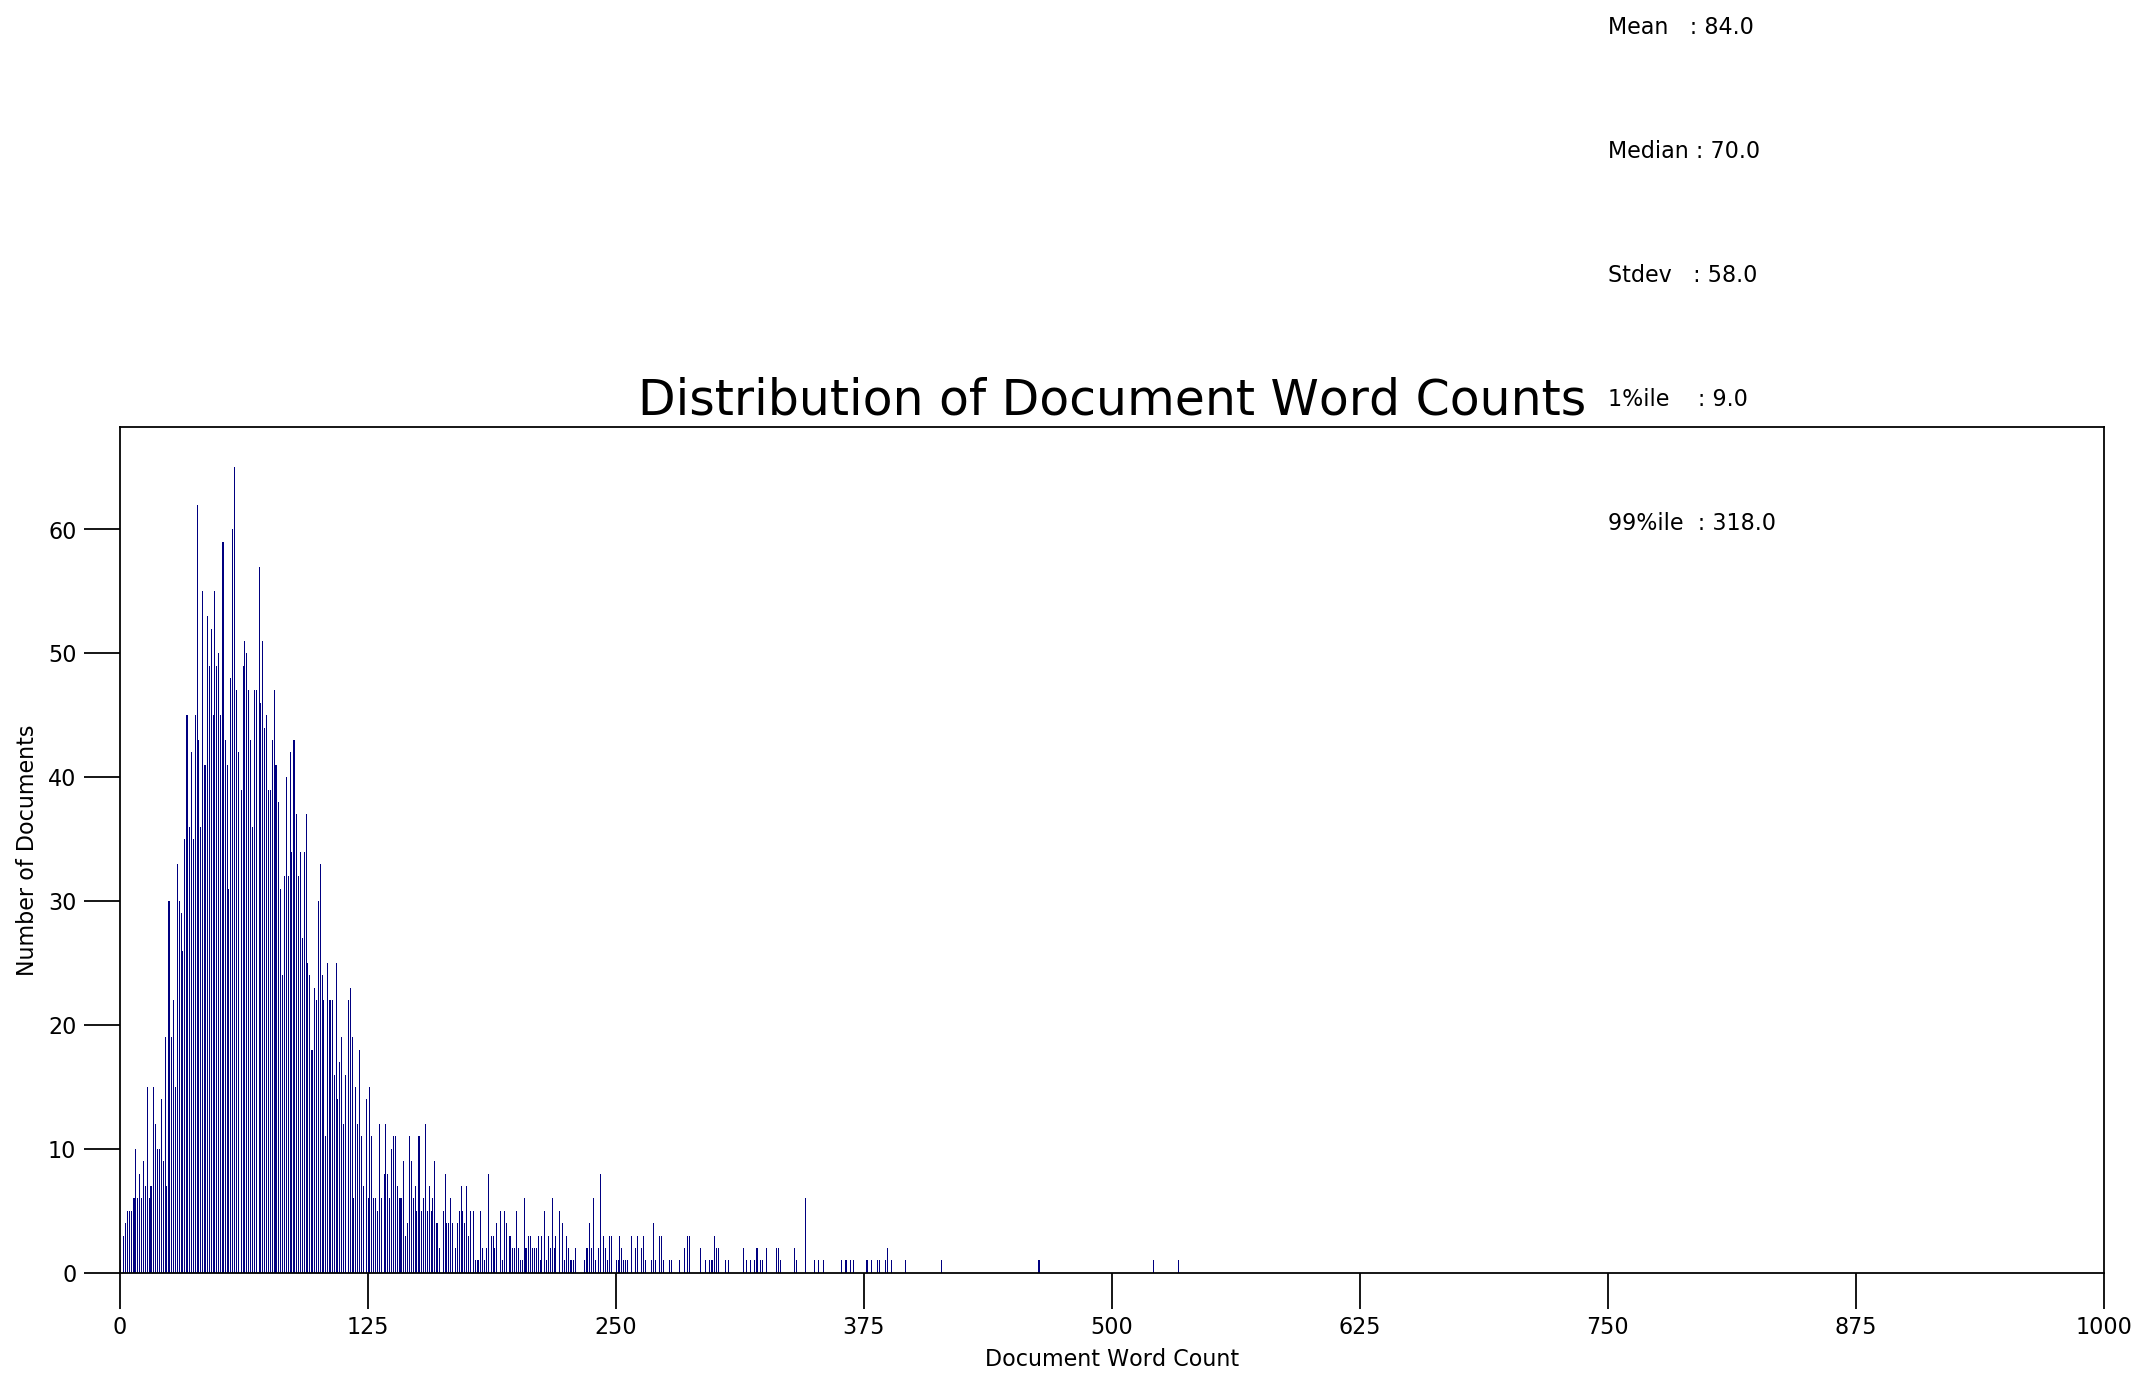

In [6]:
# Frecuencia de distribución del texto
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

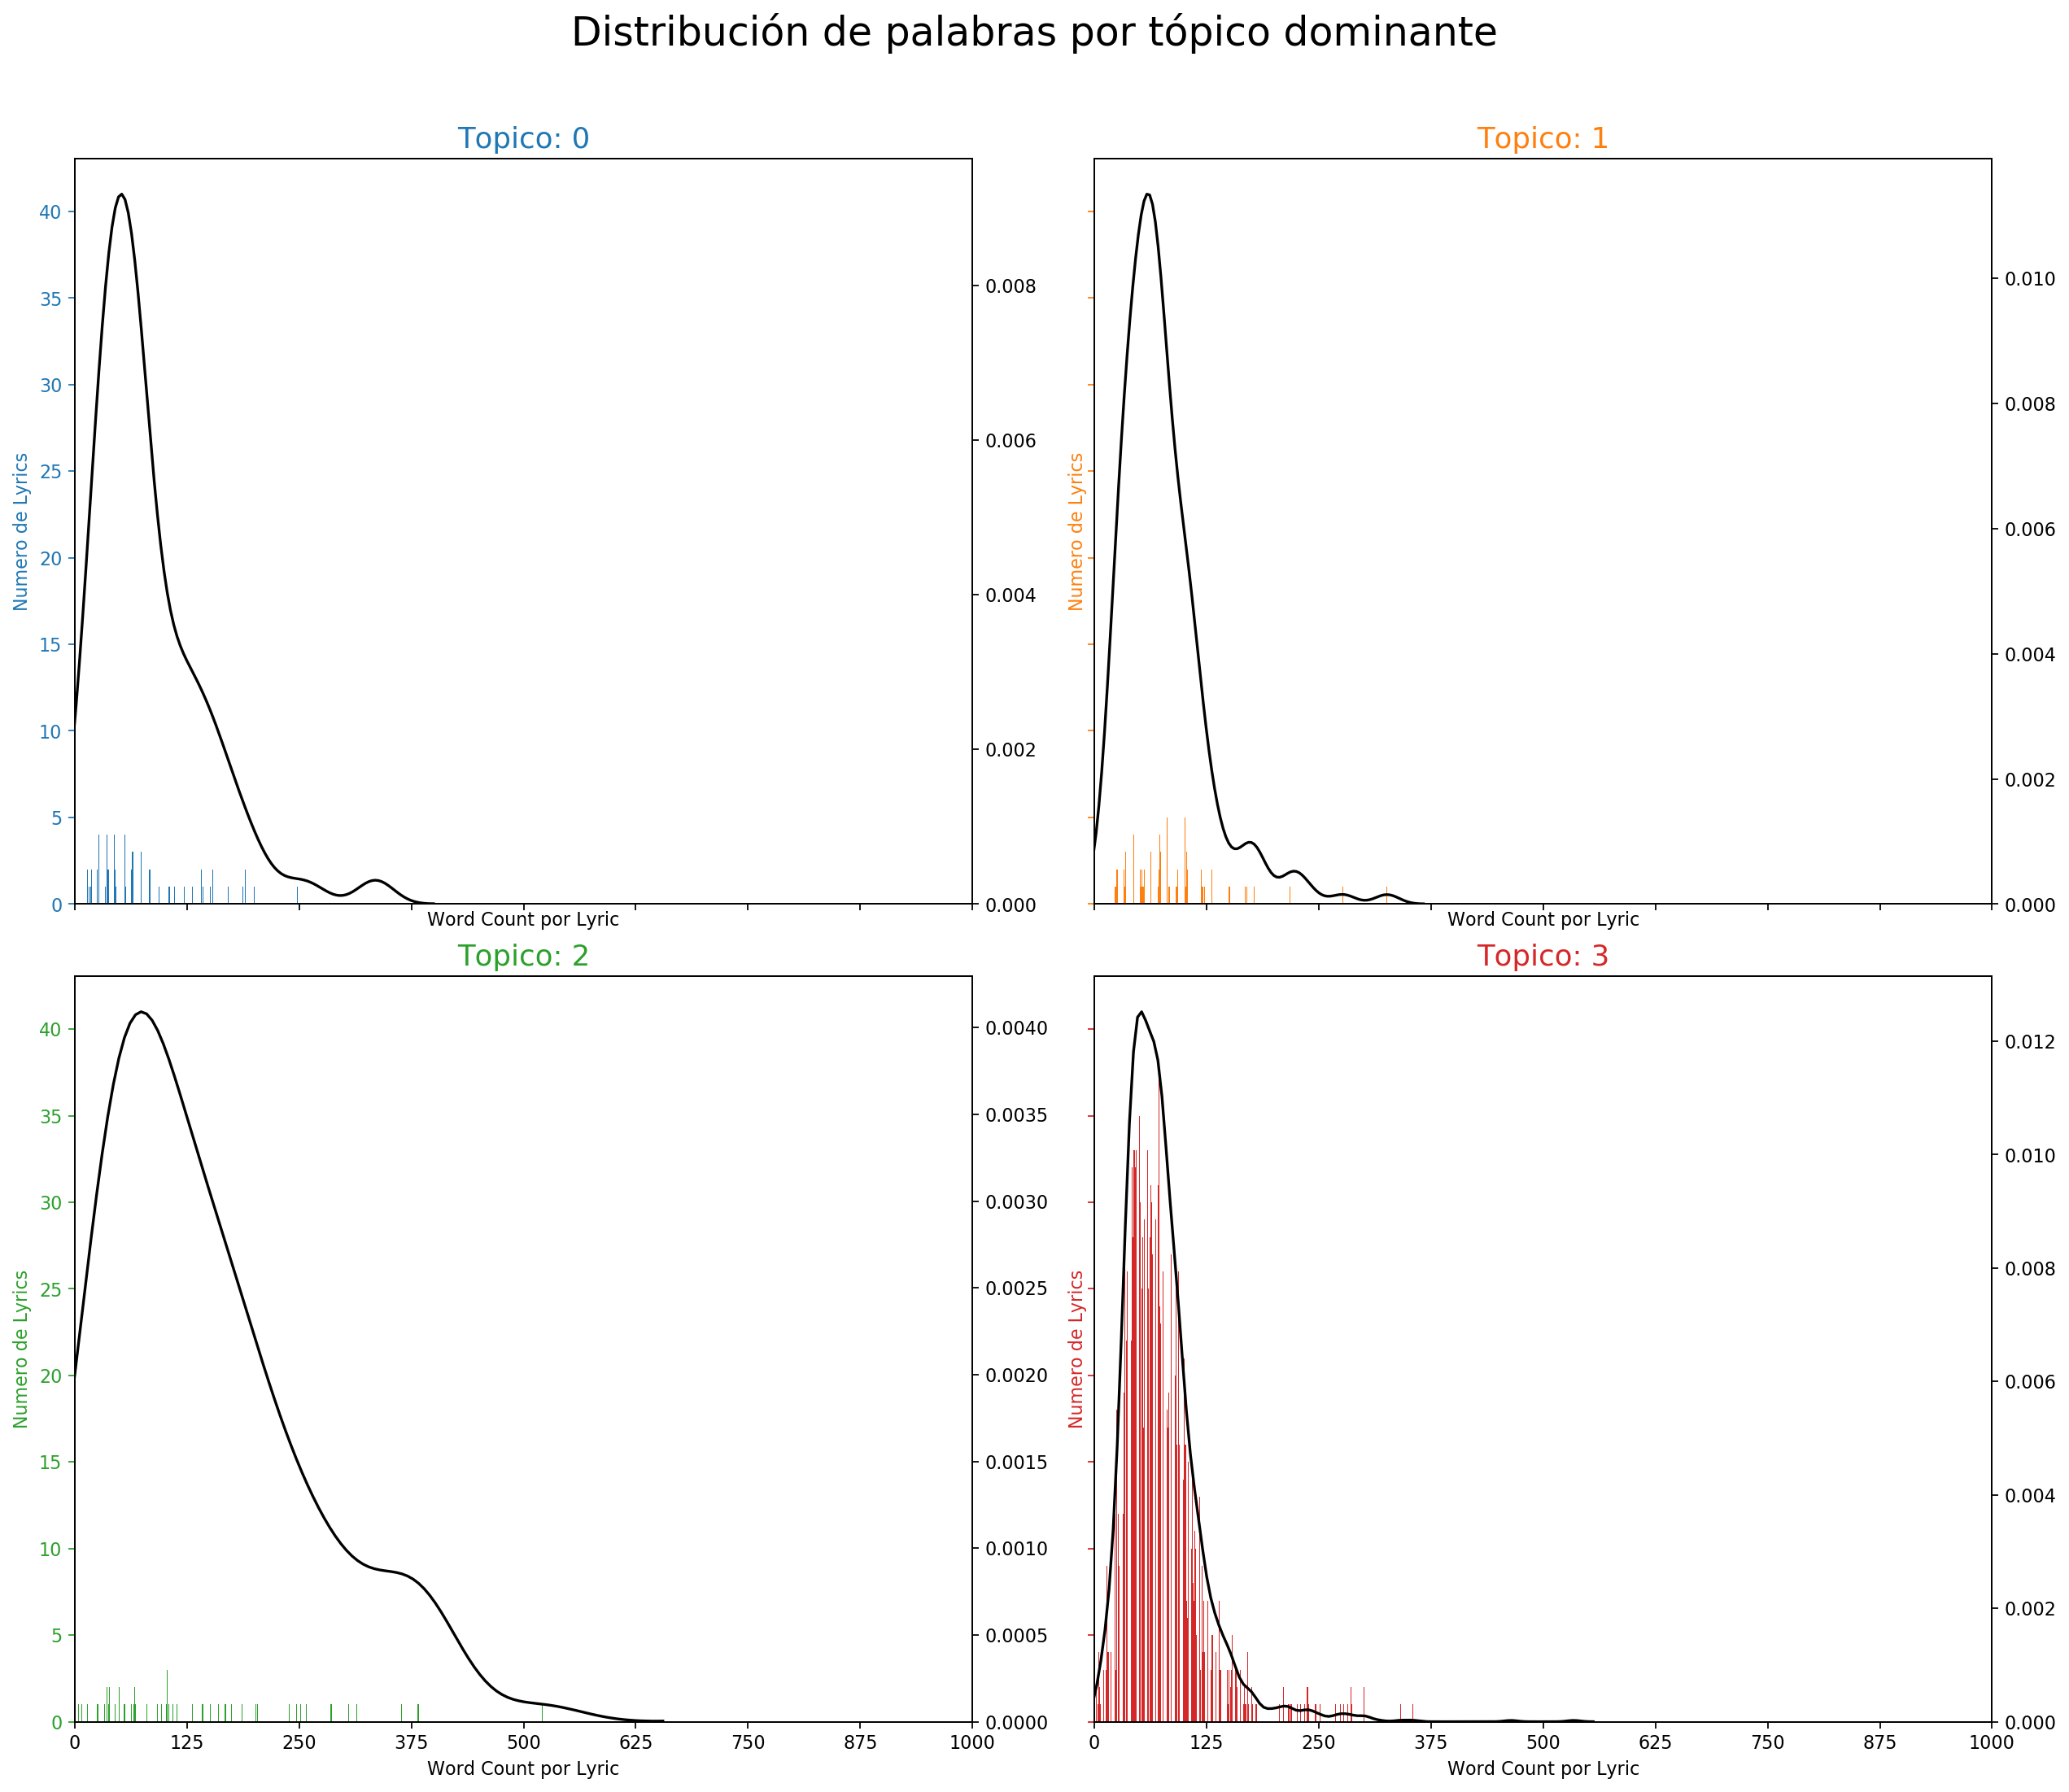

In [7]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]   

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Word Count por Lyric')
    ax.set_ylabel('Numero de Lyrics', color=cols[i])
    ax.set_title('Topico: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribución de palabras por tópico dominante', fontsize=22)
plt.show()

###  Wordcloud de las N palabras por tópico

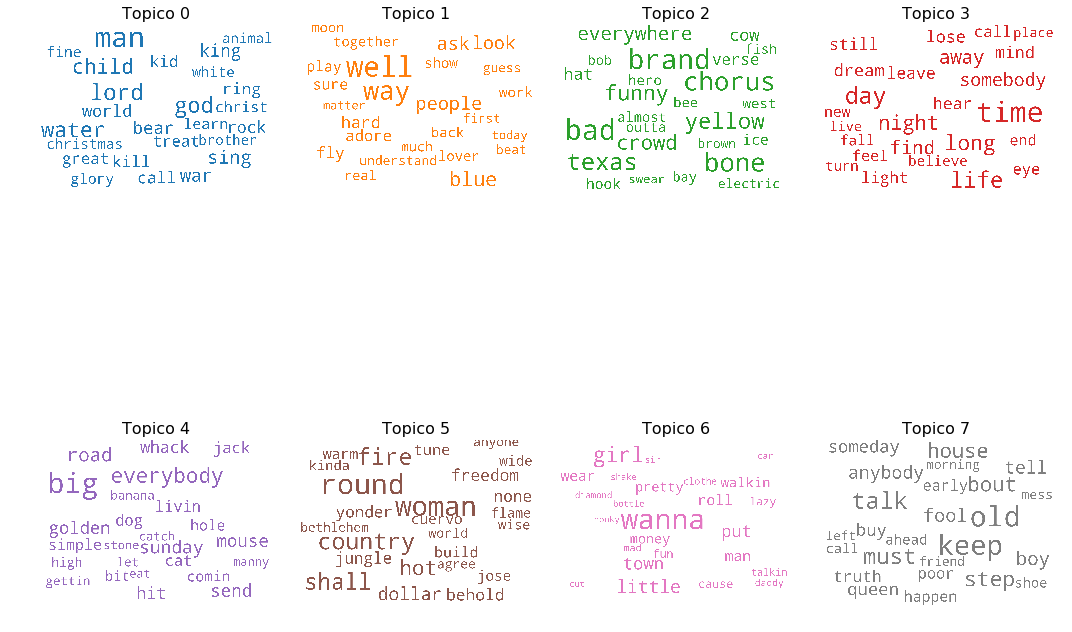

In [8]:

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=25,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_words=50)

fig, axes = plt.subplots(2, 4, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topico ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Cantidad e importancia de las palabras por tópico

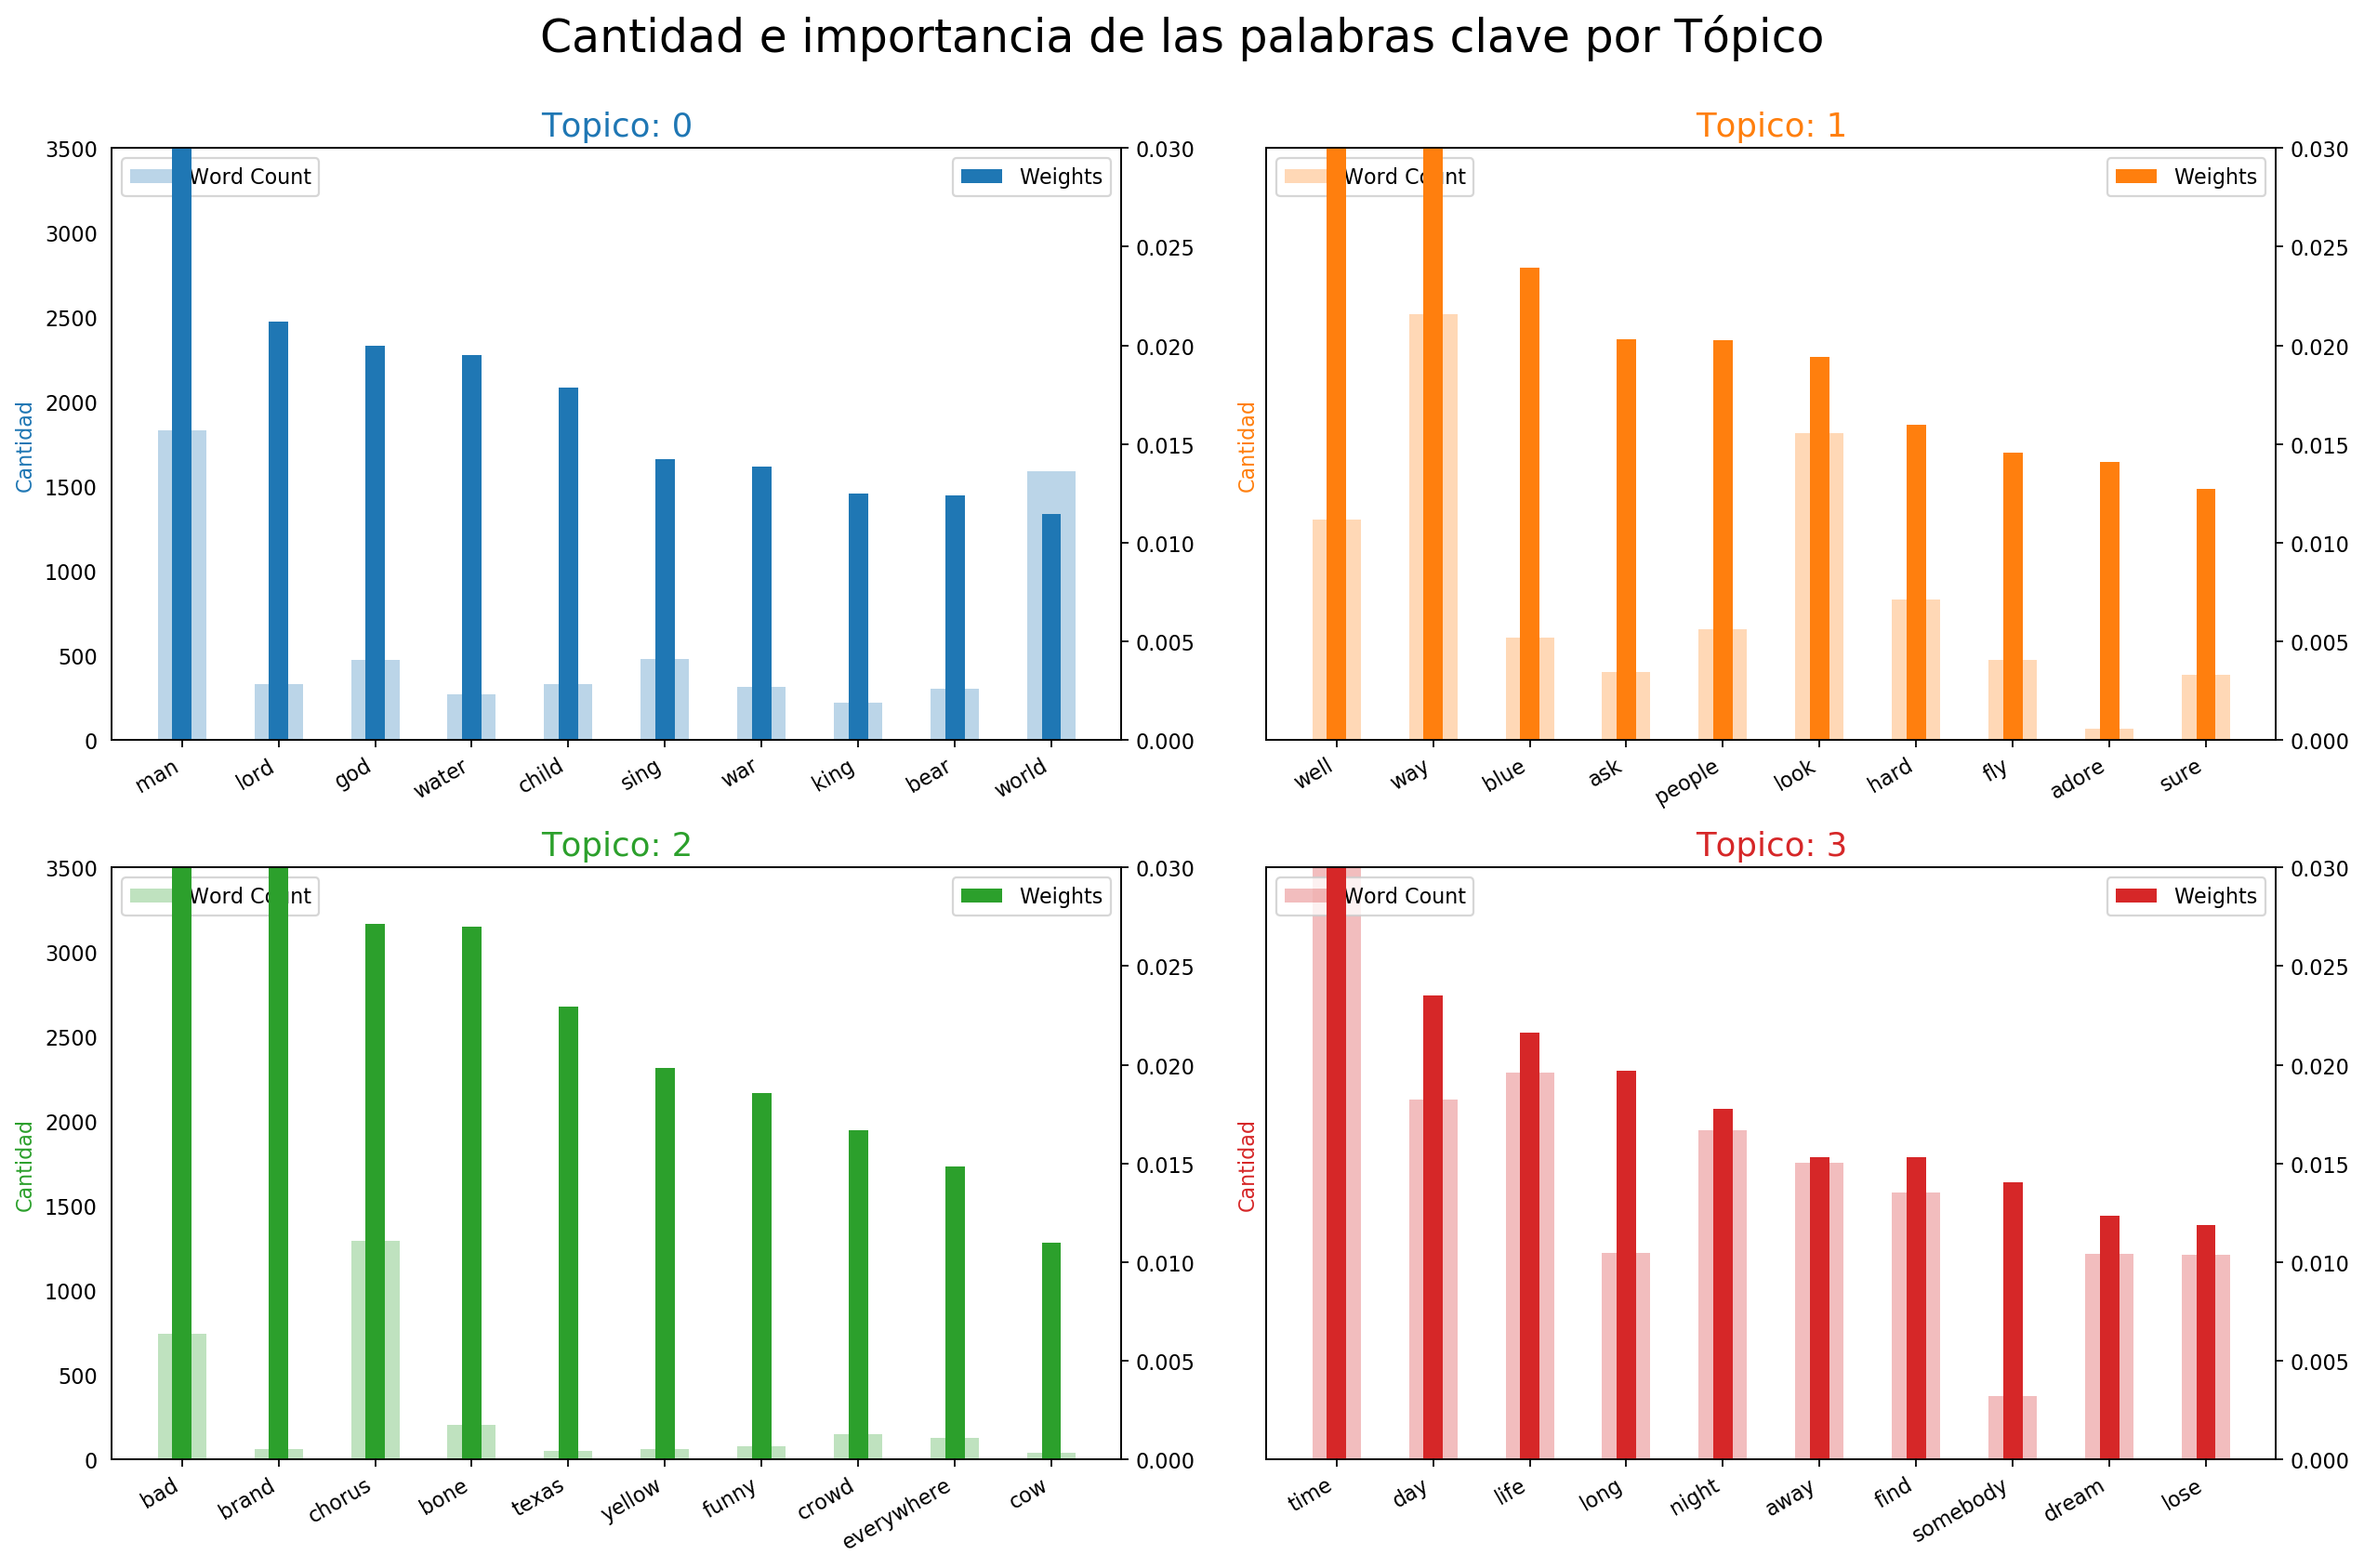

In [12]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['palabra', 'topic_id', 'importancia', 'cantidad'])        


fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='palabra', height="cantidad", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='palabra', height="importancia", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Cantidad', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topico: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'palabra'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Cantidad e importancia de las palabras clave por Tópico', fontsize=22, y=1.05)    
plt.show()

### Gráfico de palabras coloreadas por tópico

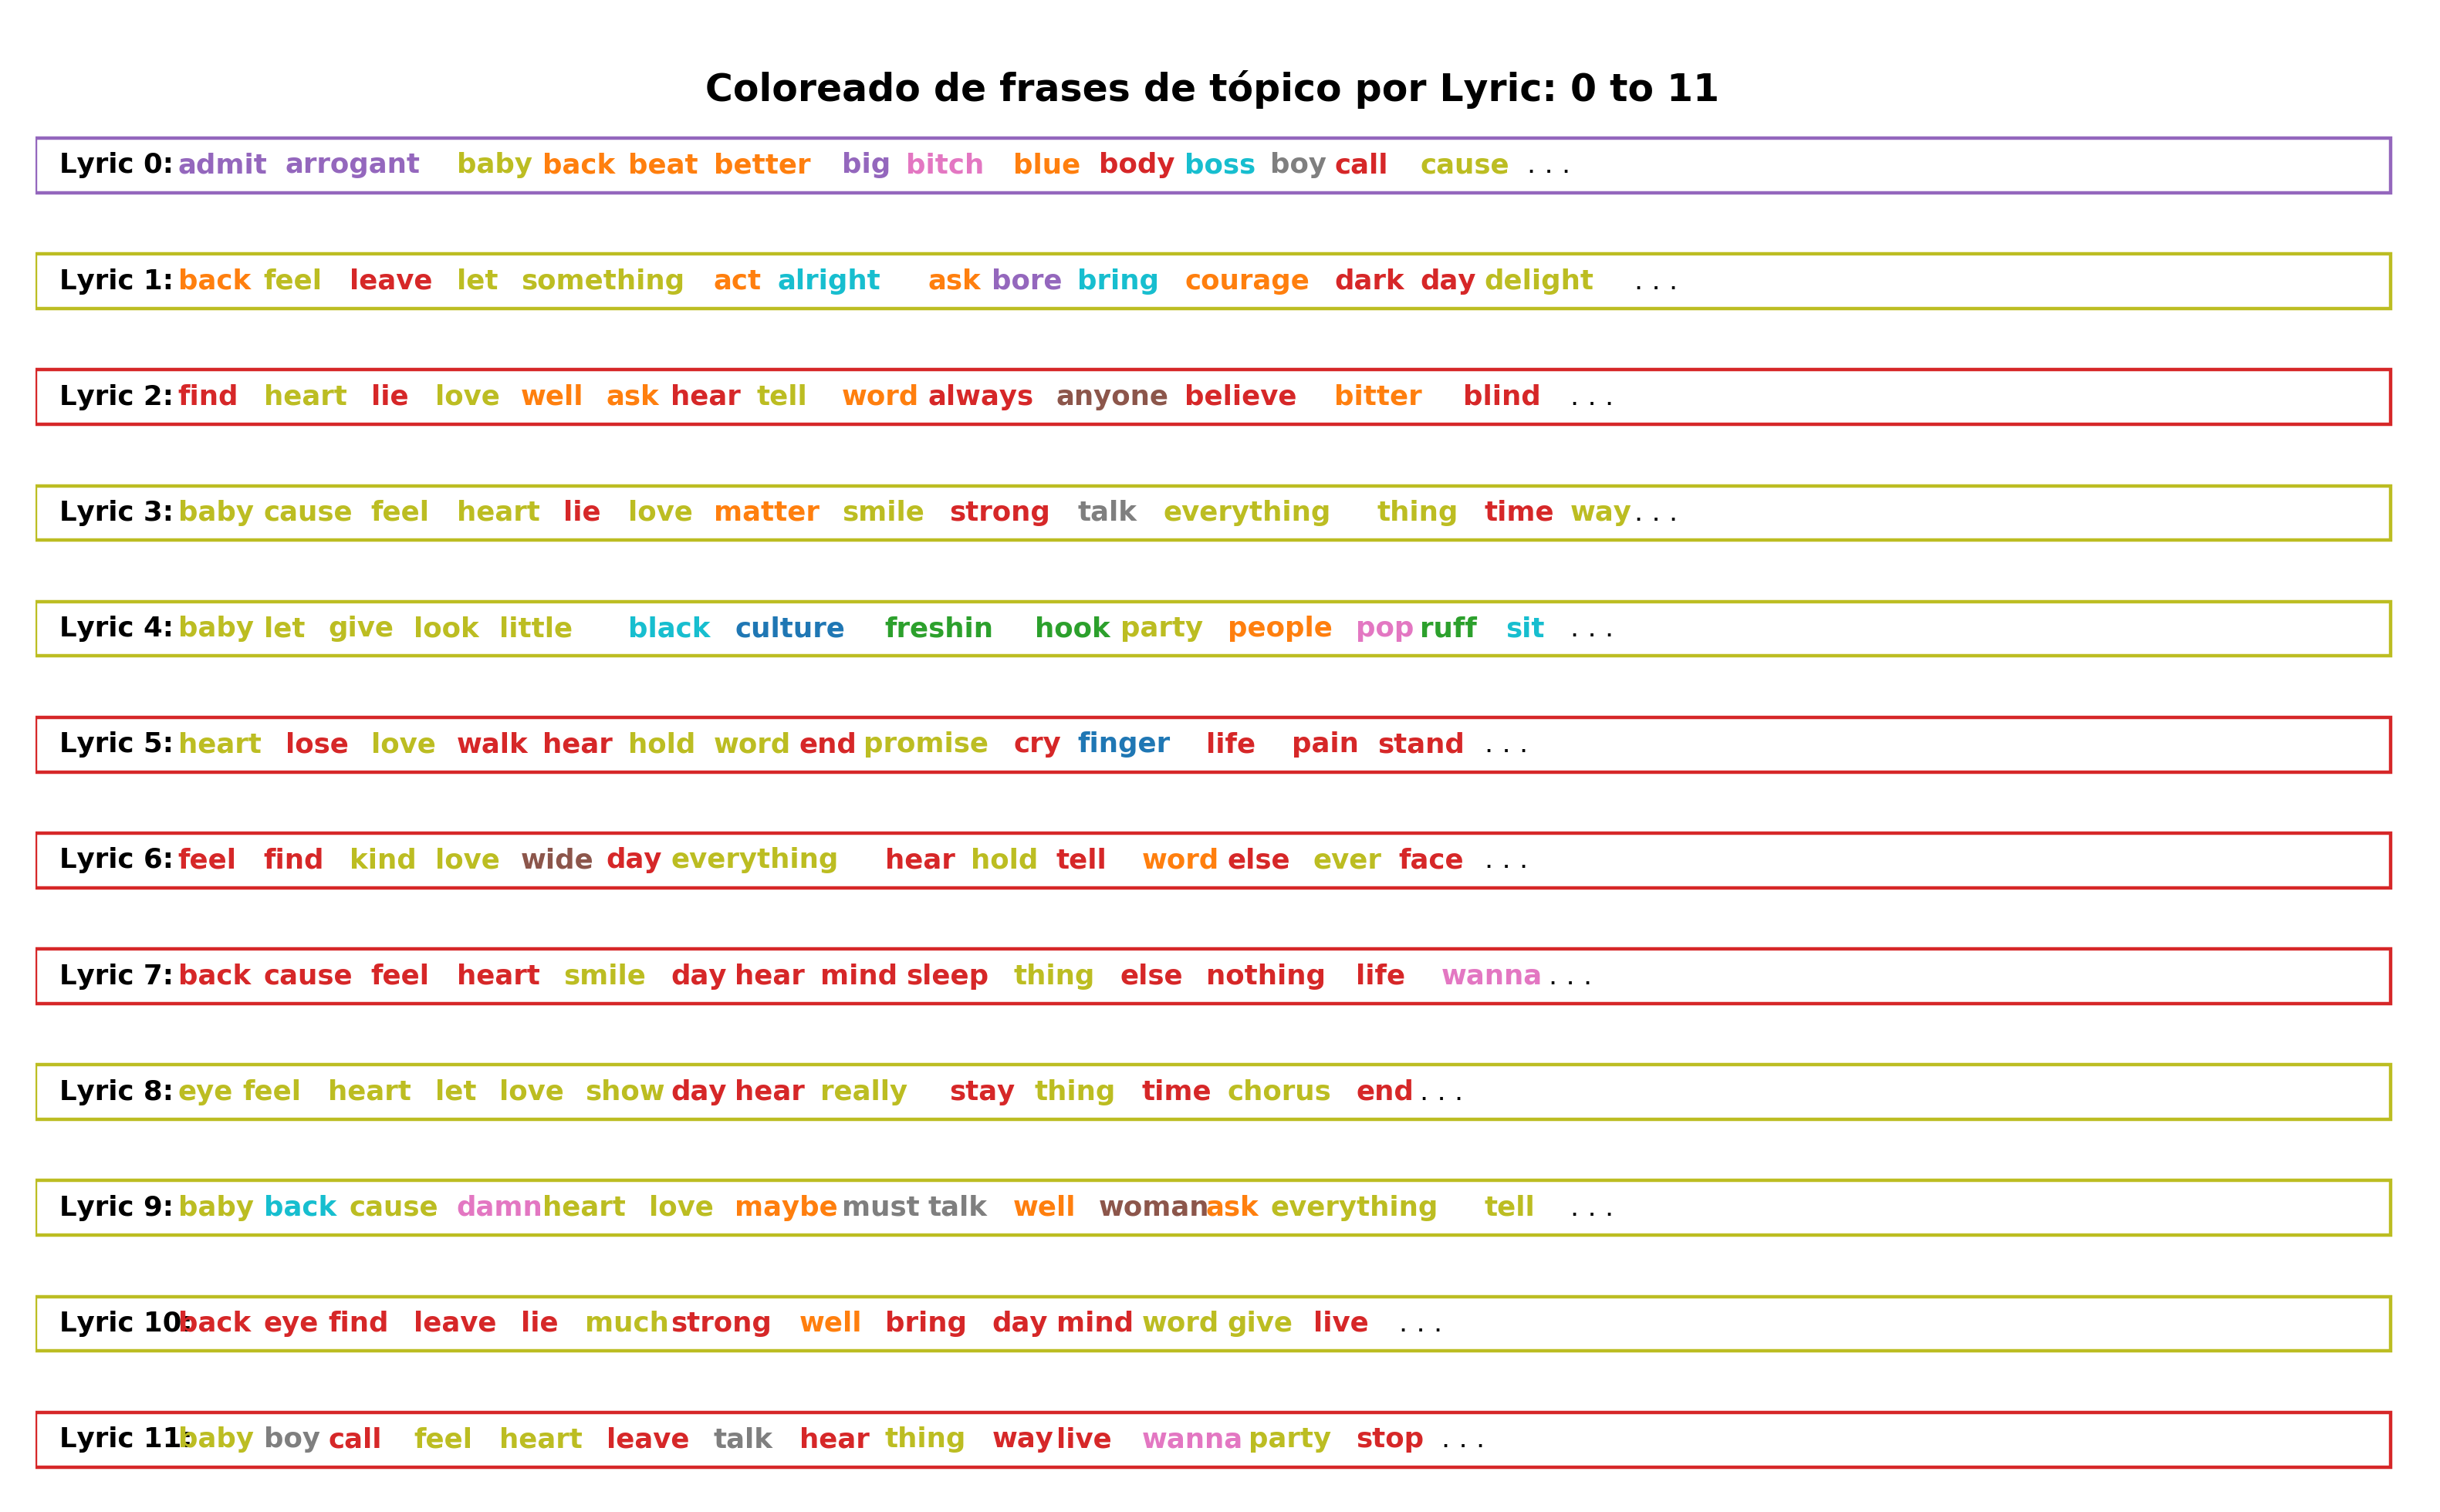

In [11]:

from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Lyric " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Coloreado de frases de tópico por Lyric: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

###  t-SNE Clustering Chart

In [9]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering de los {} Topicos LDA".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2553 samples in 0.001s...
[t-SNE] Computed neighbors for 2553 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2553
[t-SNE] Computed conditional probabilities for sample 2000 / 2553
[t-SNE] Computed conditional probabilities for sample 2553 / 2553
[t-SNE] Mean sigma: 0.079306
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.502007
[t-SNE] Error after 1000 iterations: 1.007305


Loading BokehJS ...

In [10]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.315181  0.187136       1        1  28.656313
8      0.287506 -0.076887       2        1  16.751497
1      0.128823 -0.179835       3        1  10.840270
6     -0.058932 -0.127890       4        1   8.867961
0     -0.081630 -0.167815       5        1   7.697071
4     -0.139509  0.089345       6        1   6.483405
9     -0.077836  0.201278       7        1   6.018530
7     -0.068103  0.054569       8        1   5.715606
2     -0.153917  0.021628       9        1   4.954251
5     -0.151581 -0.001528      10        1   4.015098, topic_info=      Category         Freq       Term        Total  loglift  logprob
term                                                                 
41     Default  6726.000000       love  6726.000000  30.0000  30.0000
179    Default  2402.000000      wanna  2402.000000  29.0000  29.0000
2      Default  2936.000000       baby  2936.000000  28.0000  28.0000
65     Default  2034.000000       well  2034.000000  27.0000  27.0000
102    Default  3781.000000       time  3781.000000  26.0000  26.0000
38     Default  2623.000000        let  2623.000000  25.0000  25.0000
104    Default  2857.000000        way  2857.000000  24.0000  24.0000
222    Default  2684.000000      never  2684.000000  23.0000  23.0000
271    Default  1818.000000       girl  1818.000000  22.0000  22.0000
101    Default  2121.000000      thing  2121.000000  21.0000  21.0000
157    Default  1587.000000       keep  1587.000000  20.0000  20.0000
1032   Default  1283.000000        old  1283.000000  19.0000  19.0000
6      Default  1118.000000        big  1118.000000  18.0000  18.0000
76     Default  2480.000000        day  2480.000000  17.0000  17.0000
204    Default  1688.000000        man  1688.000000  16.0000  16.0000
26     Default  2475.000000       feel  2475.000000  15.0000  15.0000
159    Default  2303.000000       life  2303.000000  14.0000  14.0000
305    Default  1031.000000       home  1031.000000  13.0000  13.0000
89     Default  1372.000000        new  1372.000000  12.0000  12.0000
241    Default  2061.000000       long  2061.000000  11.0000  11.0000
162    Default  1839.000000      night  1839.000000  10.0000  10.0000
160    Default  1608.000000     little  1608.000000   9.0000   9.0000
8      Default   937.000000       blue   937.000000   8.0000   8.0000
100    Default  2445.000000       tell  2445.000000   7.0000   7.0000
3      Default  1368.000000       back  1368.000000   6.0000   6.0000
288    Default   833.000000       town   833.000000   5.0000   5.0000
29     Default  1702.000000      heart  1702.000000   4.0000   4.0000
314    Default  1032.000000        put  1032.000000   3.0000   3.0000
112    Default   800.000000     chorus   800.000000   2.0000   2.0000
825    Default  1452.000000   somebody  1452.000000   1.0000   1.0000
...        ...          ...        ...          ...      ...      ...
4874   Topic10   170.254059     behold   171.273575   3.2091  -4.4437
1432   Topic10   168.658218       none   169.677048   3.2091  -4.4531
6510   Topic10   164.638580     jungle   165.657349   3.2089  -4.4772
8892   Topic10   165.320435     yonder   166.422134   3.2085  -4.4731
319    Topic10   150.675034       tune   151.693787   3.2084  -4.5658
232    Topic10   140.693649       warm   141.712204   3.2079  -4.6344
1631   Topic10   137.456543      build   138.474930   3.2077  -4.6577
66     Topic10   124.902840       wide   125.921402   3.2070  -4.7534
366    Topic10   120.292976      kinda   121.311638   3.2067  -4.7910
1449   Topic10   114.766289      flame   115.784485   3.2063  -4.8381
1185   Topic10   114.347260       wise   115.365883   3.2062  -4.8417
7608   Topic10   107.690155      agree   108.709221   3.2057  -4.9017
108    Topic10   105.106316     anyone   106.124649   3.2055  -4.9260
3262   Topic10   101.398483      charm   102.417068   3.2051  -4.9619
2685   Topic10    9

## Clasificación
Para el proceso de seleccionar el modelo de clasificación se preparó el dataset en esta notebook y se lo grabó como "clasificar.csv"
Continúa el pipeline con el proceso de clasificación en la siguiente notebook "Clasificación - Equipo 10"

